# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 02.02.2024

Мягкий дедлайн: 23:59MSK 19.02.2024

Жесткий дедлайн: 23:59MSK 25.02.2024

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [1]:
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(y_train.shape[0], -1)
x_test = x_test_pics.reshape(y_test.shape[0], -1)

2024-02-19 12:26:55.823592: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 12:26:55.823799: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 12:26:55.992401: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


4422102/4422102 [==============================] - 0s 0us/step


__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [2]:
import warnings
warnings.filterwarnings('ignore')


In [91]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
import random 
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import Normalizer


class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.pca = PCA(n_components=self.new_dim)
        self.model = None
        self.WT = None
        self.b = None
        self.scaler = Normalizer()
        
    def _sigma(self, x1, x2):
        return np.sum((x1 - x2) ** 2)
                
    
    def _approximate_sigma(self, X, amount_to_approximate=1500):
        sigmas = []
        random_indices = np.random.choice(X.shape[0], amount_to_approximate, replace=False)
        random_objects = X[random_indices, :]
        for i in tqdm(range(amount_to_approximate)):
            for j in range(i + 1, amount_to_approximate):
                sigmas.append(self._sigma(random_objects[i], random_objects[j]))
        return np.median(sigmas)
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        X_pca = self.scaler.fit_transform(X)
        if self.use_PCA:
            X_pca = self.pca.fit_transform(X_pca)
        else:
            self.new_dim = X_pca.shape[1]
        sigma = self._approximate_sigma(X_pca)
        mean = np.zeros(self.new_dim)
        cov = 1 / sigma * np.identity(self.new_dim)
        W = np.random.multivariate_normal(mean, cov, self.n_features)
        B = np.random.uniform(-np.pi, np.pi, (self.n_features, 1)).T
        self.WT = W.T
        self.b = B
        new_features = np.cos(X_pca @ W.T + B)
        if self.classifier == 'logreg':
            self.model = LogisticRegression()
        else:
            self.model = SVC(kernel='linear')
        self.model.fit(new_features, y)
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        X_pca = self.scaler.transform(X)
        if self.use_PCA:
            X_pca = self.pca.transform(X_pca)
        new_features = np.cos(X_pca @ self.WT + self.b)
        pred = self.model.predict_proba(new_features)[:, 1]
        return pred
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X_pca = self.scaler.transform(X)
        if self.use_PCA:
            X_pca = self.pca.transform(X_pca)
        new_features = np.cos(X_pca @ self.WT + self.b)
        y_pred = self.model.predict(new_features)
        return y_pred

In [5]:
def accuracy(y_true, y_pred):
    return np.sum(y_pred == y_true) / len(y_pred)

In [5]:
m = RFFPipeline()
m.fit(x_train, y_train)
y_pred = m.predict(x_test)
print('Accuracy:', accuracy(y_test, y_pred))

100%|██████████| 1500/1500 [00:10<00:00, 141.37it/s]


Accuracy: 0.8608


__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

Я попытался запустить SVM на исходных данных и это очень долго. Поэтому будем сравнивать все методы на подвыборке из датасета размером 10тыс

In [7]:
random_indices = np.random.choice(x_train.shape[0], 10_000, replace=False)
x_train_sub = x_train[random_indices, :]
y_train_sub = y_train[random_indices]

In [12]:
from sklearn.svm import LinearSVC
import time

In [8]:
cur_time = time.time()
linear_svm = LinearSVC()
linear_svm.fit(x_train_sub, y_train_sub)
y_pred = linear_svm.predict(x_test)
print('Accuracy for default features linear SVM:', accuracy(y_pred, y_test))
print('Time:', time.time() - cur_time)

Accuracy for default features linear SVM: 0.7688
Time: 36.93769454956055


In [13]:
cur_time = time.time()
rff = RFFPipeline()
rff.fit(x_train_sub, y_train_sub)
y_pred = rff.predict(x_test)
print('Accuracy for RFF linreg:', accuracy(y_test, y_pred))
print('Time:', time.time() - cur_time)

100%|██████████| 1500/1500 [00:05<00:00, 254.05it/s]


Accuracy for RFF linreg: 0.8516
Time: 10.979458570480347


In [14]:
cur_time = time.time()
rff = RFFPipeline(classifier='svm')
rff.fit(x_train_sub, y_train_sub)
y_pred = rff.predict(x_test)
print('Accuracy for RFF svm:', accuracy(y_test, y_pred))
print('Time:', time.time() - cur_time)

100%|██████████| 1500/1500 [00:05<00:00, 255.25it/s]


Accuracy for RFF svm: 0.8602
Time: 36.43124079704285


In [11]:
cur_time = time.time()
linear_svm = SVC(kernel='rbf')
linear_svm.fit(x_train_sub, y_train_sub)
y_pred = linear_svm.predict(x_test)
print('Accuracy for default features rbf kernel SVM:', accuracy(y_pred, y_test))
print('Time:', time.time() - cur_time)

Accuracy for default features rbf kernel SVM: 0.8491
Time: 47.99574303627014


In [12]:
from catboost import CatBoostClassifier

pca = PCA(n_components=50)

x_train_sub_pca = pca.fit_transform(x_train_sub)
x_test_pca = pca.transform(x_test)

In [21]:
import optuna 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


x_train_pca, x_val_pca, y_train_pca, y_val_pca = train_test_split(x_train_sub_pca, y_train_sub, test_size=0.25, random_state=42)

def cat_optimization(trial):
    num_trees = trial.suggest_int('num_trees', 2, 150)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1)

    catboost_model = CatBoostClassifier(num_trees=num_trees, learning_rate=learning_rate, verbose=0)
    catboost_model.fit(x_train_pca, y_train_pca)
    pred = catboost_model.predict(x_val_pca)
    return accuracy_score(y_val_pca, pred)

study = optuna.create_study(direction='maximize')
study.optimize(cat_optimization, n_trials=10)

best_params = study.best_params
print(best_params)
print(study.best_trial)


[I 2024-02-16 21:56:22,765] A new study created in memory with name: no-name-3c88c19b-8c0d-4e88-973f-1948e9dfbbd4
[I 2024-02-16 21:56:25,788] Trial 0 finished with value: 0.784 and parameters: {'num_trees': 36, 'learning_rate': 0.1102428469118672}. Best is trial 0 with value: 0.784.
[I 2024-02-16 21:56:29,148] Trial 1 finished with value: 0.816 and parameters: {'num_trees': 41, 'learning_rate': 0.3431481067469977}. Best is trial 1 with value: 0.816.
[I 2024-02-16 21:56:29,780] Trial 2 finished with value: 0.6552 and parameters: {'num_trees': 4, 'learning_rate': 0.05749985133488738}. Best is trial 1 with value: 0.816.
[I 2024-02-16 21:56:31,387] Trial 3 finished with value: 0.764 and parameters: {'num_trees': 17, 'learning_rate': 0.9630104816474904}. Best is trial 1 with value: 0.816.
[I 2024-02-16 21:56:35,506] Trial 4 finished with value: 0.822 and parameters: {'num_trees': 44, 'learning_rate': 0.3711365202074827}. Best is trial 4 with value: 0.822.
[I 2024-02-16 21:56:41,733] Trial 5

{'num_trees': 125, 'learning_rate': 0.2372509518668741}
FrozenTrial(number=8, state=TrialState.COMPLETE, values=[0.838], datetime_start=datetime.datetime(2024, 2, 16, 21, 57, 3, 351240), datetime_complete=datetime.datetime(2024, 2, 16, 21, 57, 13, 374435), params={'num_trees': 125, 'learning_rate': 0.2372509518668741}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_trees': IntDistribution(high=150, log=False, low=2, step=1), 'learning_rate': FloatDistribution(high=1.0, log=False, low=0.01, step=None)}, trial_id=8, value=None)


In [22]:
cur_time = time.time()
catboost_model = CatBoostClassifier(**best_params, verbose=0)
catboost_model.fit(x_train_sub_pca, y_train_sub)
pred = catboost_model.predict(x_test_pca)
print('Accurcy for Catboost with PCA:', accuracy_score(pred, y_test))
print('Time:', time.time() - cur_time)

Accurcy for Catboost with PCA: 0.8261
Time: 11.792359590530396


Во-первых, обычный свм на всех признаках показал себя хуже всего.

Наш метод со случайнми фичами показал себя очень хорошо, причем как на свм, так и на логреге. Поэтому очевидно, что метод хорош и имеет смысл им пользоваться. 

Ядровой svm показал себя тоже отлично, хотя accuracy чуть хуже, чем у RFF

Катбуст немного проиграл RFF, но, возможно, что нужно было перебирать больше гиперпараметров. Плюс ко всему, я учу модели на достаточно маленькой подвыборке, что тоже могло плохо сказаться на катбусте. 

Также можно заметить, что RFF отрабатывал очень быстро и выигрывает по времени у остальных методов (кроме катбуста, который учится быстрее всех)

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

In [23]:
m = RFFPipeline()
m.fit(x_train, y_train)
y_pred = m.predict(x_test)
print('Accuracy:', accuracy(y_test, y_pred))

100%|██████████| 1500/1500 [00:10<00:00, 140.81it/s]


Accuracy: 0.8586


In [28]:
m1 = RFFPipeline(use_PCA=False)
m1.fit(x_train, y_train)
y_pred = m1.predict(x_test)
print('Accuracy:', accuracy(y_test, y_pred))

100%|██████████| 1500/1500 [00:14<00:00, 102.39it/s]


Accuracy: 0.8669


Видим, что с PCA accuracy немного меньше. Однако мы сильно экономим память и обрабатываем меньше фичей. Поэтому, если эффективность важна, можно юзать PCA и не сильно терять в качестве.

In [8]:
n_features = np.linspace(10, 1700, 25)
accuracies = []

for n_feature in n_features:
    rff = RFFPipeline(n_features=int(n_feature))
    rff.fit(x_train_sub, y_train_sub)
    y_pred = rff.predict(x_test)
    accuracies.append(accuracy(y_test, y_pred))

100%|██████████| 1500/1500 [00:05<00:00, 257.16it/s]


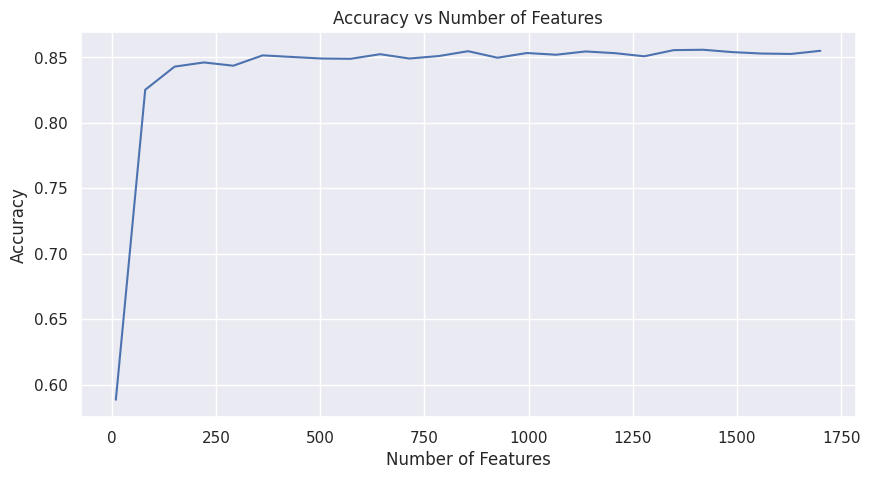

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")
plt.figure(figsize=(10, 5))

sns.lineplot(x=n_features, y=accuracies)

plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Features')

plt.show()


Видно, что качество растет с увеличением n_features, но где-то после 100-150 выходит на плато. Можно сделать вывод, что это довольно полезный гиперпараметр и стоит его подбирать, чтобы добиваться хорошего качества и эффективности.

In [15]:
rff = RFFPipeline(classifier='logreg')
rff.fit(x_train_sub, y_train_sub)
y_pred = rff.predict(x_test)
print('Accuracy for RFF logreg:', accuracy(y_test, y_pred))

100%|██████████| 1500/1500 [00:05<00:00, 253.03it/s]


Accuracy for RFF logreg: 0.8557


In [17]:
rff = RFFPipeline(classifier='svm')
rff.fit(x_train_sub, y_train_sub)
y_pred = rff.predict(x_test)
print('Accuracy for RFF svm:', accuracy(y_test, y_pred))

100%|██████████| 1500/1500 [00:05<00:00, 252.68it/s]


Accuracy for RFF svm: 0.8597


Видим, что для SVM наш RFF работает лучше: получили лучшее качество. Это довольно ожидаемый результат, ведь переформулировали задачу в терминах ядер мы именно для SVM. Поэтому можно сделать вывод, что лучше использовать RFF вместе с SVM.

### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

In [87]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
import random 
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import Normalizer


class ORFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.pca = PCA(n_components=self.new_dim)
        self.model = None
        self.WT = None
        self.b = None
        self.scaler = Normalizer()
        
    def _sigma(self, x1, x2):
        return np.sum((x1 - x2) ** 2)
                
    
    def _approximate_sigma(self, X, amount_to_approximate=1500):
        sigmas = []
        random_indices = np.random.choice(X.shape[0], amount_to_approximate, replace=False)
        random_objects = X[random_indices, :]
        for i in tqdm(range(amount_to_approximate)):
            for j in range(i + 1, amount_to_approximate):
                sigmas.append(self._sigma(random_objects[i], random_objects[j]))
        return np.median(sigmas)
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        X_pca = self.scaler.fit_transform(X)
        if self.use_PCA:
            X_pca = self.pca.fit_transform(X_pca)
        else:
            self.new_dim = X_pca.shape[1]
        sigma = self._approximate_sigma(X_pca)
        
        if self.n_features <= X_pca.shape[1]:
            W = np.random.normal(loc=0, scale=1, size=(X_pca.shape[1], X_pca.shape[1]))
            Q, _ = np.linalg.qr(W)
            S = np.sqrt(np.random.chisquare(X_pca.shape[1], size=X_pca.shape[1]))
            self.W = ((Q @ np.diag(S)) / np.sqrt(sigma))[:, :self.n_features]
        else:
            W_indep = []
            for _ in range(self.n_features // X_pca.shape[1]):
                W = np.random.normal(loc=0, scale=1, size=(X_pca.shape[1], X_pca.shape[1]))
                Q, _ = np.linalg.qr(W)
                S = np.sqrt(np.random.chisquare(X_pca.shape[1], size=X_pca.shape[1]))
                W_indep.append((Q @ np.diag(S)) / np.sqrt(sigma))
            self.W = np.hstack(W_indep)
        
        self.n_features = self.W.shape[1]
        self.b = np.random.uniform(-np.pi, np.pi, (1, self.n_features))
        
        new_features = np.cos(X_pca @ self.W + self.b)
        if self.classifier == 'logreg':
            self.model = LogisticRegression()
        else:
            self.model = SVC(kernel='linear')
        self.model.fit(new_features, y)
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        X_pca = self.scaler.transform(X)
        if self.use_PCA:
            X_pca = self.pca.transform(X_pca)
        new_features = np.cos(X_pca @ self.W + self.b)
        pred = self.model.predict_proba(new_features)[:, 1]
        return pred
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X_pca = self.scaler.transform(X)
        if self.use_PCA:
            X_pca = self.pca.transform(X_pca)
        new_features = np.cos(X_pca @ self.W + self.b)
        y_pred = self.model.predict(new_features)
        return y_pred

In [88]:
orf = ORFPipeline()
orf.fit(x_train, y_train)
y_pred = orf.predict(x_test)
print('Accuracy for ORF:', accuracy(y_test, y_pred))

100%|██████████| 1500/1500 [00:10<00:00, 141.63it/s]


Accuracy for ORF: 0.8636


In [92]:
rff = RFFPipeline()
rff.fit(x_train, y_train)
y_pred = rff.predict(x_test)
print('Accuracy for RFF:', accuracy(y_test, y_pred))

100%|██████████| 1500/1500 [00:10<00:00, 142.68it/s]


Accuracy for ORF: 0.8593


In [94]:
n_features = np.linspace(10, 1200, 20)
accuracies = []

for n_feature in n_features:
    orf = ORFPipeline(n_features=int(n_feature))
    orf.fit(x_train, y_train)
    y_pred = orf.predict(x_test)
    accuracies.append(accuracy(y_test, y_pred))

100%|██████████| 1500/1500 [00:10<00:00, 143.68it/s]


In [95]:
print(max(accuracies))

0.8617


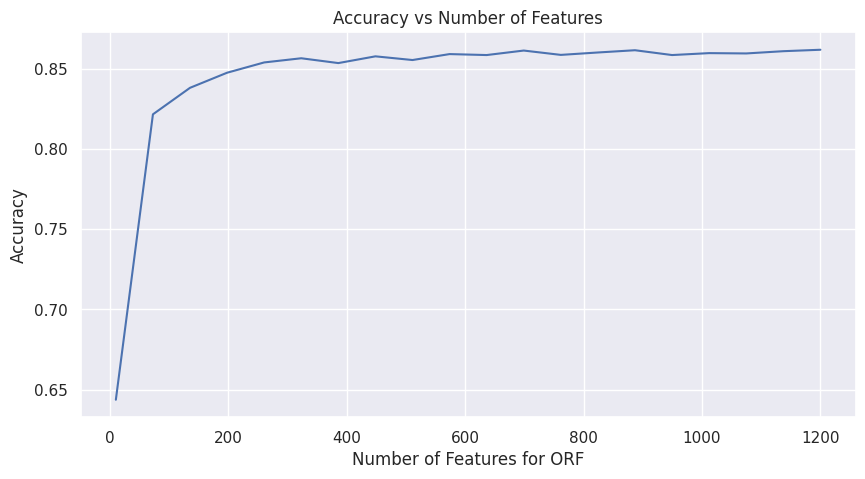

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")
plt.figure(figsize=(10, 5))

sns.lineplot(x=n_features, y=accuracies)

plt.xlabel('Number of Features for ORF')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Features')

plt.show()


Как видим, стало немного лучше, но я бы не сказал, что значительно. 

Accuracy вырос совсем чуть-чуть. Метод точно не хуже RFF и может быть даже чуть, имеет смысл его использовать.

Также можно видеть, что n_features для ORF требуется немного больше, чем для RFF. Это может негативно сказываться на эффективности.

Также можно сделать вывод, что ORF в целом немного медленнее, так как мы используем QR разложение, что негативно сказывается на сложности вычислений. 


__Задание 5. (Максимум 1 балл)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

попробуем заюзать синус, знак косинуса, relu и сигмоиду 

In [37]:
def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg', use_sin=False, use_sign=False, use_relu=False, use_sigmoid=False):
        """
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.pca = PCA(n_components=self.new_dim)
        self.model = None
        self.WT = None
        self.b = None
        self.scaler = Normalizer()
        self.use_sin = use_sin
        self.use_sign = use_sign
        self.use_relu = use_relu
        self.use_sigmoid = use_sigmoid
        
    def _sigma(self, x1, x2):
        return np.sum((x1 - x2) ** 2)
                
    
    def _approximate_sigma(self, X, amount_to_approximate=1500):
        sigmas = []
        random_indices = np.random.choice(X.shape[0], amount_to_approximate, replace=False)
        random_objects = X[random_indices, :]
        for i in tqdm(range(amount_to_approximate)):
            for j in range(i + 1, amount_to_approximate):
                sigmas.append(self._sigma(random_objects[i], random_objects[j]))
        return np.median(sigmas)
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        X_pca = self.scaler.fit_transform(X)
        if self.use_PCA:
            X_pca = self.pca.fit_transform(X_pca)
        else:
            self.new_dim = X_pca.shape[1]
        sigma = self._approximate_sigma(X_pca)
        mean = np.zeros(self.new_dim)
        cov = 1 / sigma * np.identity(self.new_dim)
        W = np.random.multivariate_normal(mean, cov, self.n_features)
        B = np.random.uniform(-np.pi, np.pi, (self.n_features, 1)).T
        self.WT = W.T
        self.b = B
        if self.use_sin:
            new_features = np.sin(X_pca @ W.T + B)
        elif self.use_sign:
            new_features = np.sign(np.cos(X_pca @ self.WT + self.b))
        elif self.use_relu:
            new_features = relu(X_pca @ W.T + B)
        elif self.use_sigmoid:
            new_features = sigmoid(X_pca @ self.WT + self.b)
        else:
            new_features = np.cos(X_pca @ W.T + B)
        if self.classifier == 'logreg':
            self.model = LogisticRegression()
        else:
            self.model = SVC(kernel='linear')
        self.model.fit(new_features, y)
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        X_pca = self.scaler.transform(X)
        if self.use_PCA:
            X_pca = self.pca.transform(X_pca)
        if self.use_sin:
            new_features = np.sin(X_pca @ self.WT + self.b)
        elif self.use_sign:
            new_features = np.sign(np.cos(X_pca @ self.WT + self.b))
        elif self.use_relu:
            new_features = relu(X_pca @ self.WT + self.b)
        elif self.use_sigmoid:
            new_features = sigmoid(X_pca @ self.WT + self.b)
        else:
            new_features = np.cos(X_pca @ self.WT + self.b)
        pred = self.model.predict_proba(new_features)[:, 1]
        return pred
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X_pca = self.scaler.transform(X)
        if self.use_PCA:
            X_pca = self.pca.transform(X_pca)
        if self.use_sin:
            new_features = np.sin(X_pca @ self.WT + self.b)
        elif self.use_sign:
            new_features = np.sign(np.cos(X_pca @ self.WT + self.b))
        elif self.use_relu:
            new_features = relu(X_pca @ self.WT + self.b)
        elif self.use_sigmoid:
            new_features = sigmoid(X_pca @ self.WT + self.b)
        else:
            new_features = np.cos(X_pca @ self.WT + self.b)
        y_pred = self.model.predict(new_features)
        return y_pred

In [27]:
rff = RFFPipeline(use_sin=True)
rff.fit(x_train_sub, y_train_sub)
y_pred = rff.predict(x_test)
print('Accuracy for sin:', accuracy(y_test, y_pred))

100%|██████████| 1500/1500 [00:05<00:00, 256.31it/s]


Accuracy for sin: 0.8532


In [38]:
rff = RFFPipeline(use_sign=True)
rff.fit(x_train_sub, y_train_sub)
y_pred = rff.predict(x_test)
print('Accuracy for sign:', accuracy(y_test, y_pred))

100%|██████████| 1500/1500 [00:05<00:00, 251.50it/s]


Accuracy for sign: 0.814


In [29]:
rff = RFFPipeline(use_relu=True)
rff.fit(x_train_sub, y_train_sub)
y_pred = rff.predict(x_test)
print('Accuracy for relu:', accuracy(y_test, y_pred))

100%|██████████| 1500/1500 [00:05<00:00, 258.52it/s]


Accuracy for relu: 0.8317


In [31]:
rff = RFFPipeline(use_sigmoid=True)
rff.fit(x_train_sub, y_train_sub)
y_pred = rff.predict(x_test)
print('Accuracy for relu:', accuracy(y_test, y_pred))

100%|██████████| 1500/1500 [00:05<00:00, 254.91it/s]


Accuracy for relu: 0.8164


Как видим, нормальный результат дал только синус и relu. Хотя остальные в целом тоже не так плохи, но скор заметно меньше

Теперь попробуем использовать RandomForestClassifier

In [39]:
from sklearn.ensemble import RandomForestClassifier


def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg', use_sin=False, use_sign=False, use_relu=False, use_sigmoid=False):
        """
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.pca = PCA(n_components=self.new_dim)
        self.model = None
        self.WT = None
        self.b = None
        self.scaler = Normalizer()
        self.use_sin = use_sin
        self.use_sign = use_sign
        self.use_relu = use_relu
        self.use_sigmoid = use_sigmoid
        
    def _sigma(self, x1, x2):
        return np.sum((x1 - x2) ** 2)
                
    
    def _approximate_sigma(self, X, amount_to_approximate=1500):
        sigmas = []
        random_indices = np.random.choice(X.shape[0], amount_to_approximate, replace=False)
        random_objects = X[random_indices, :]
        for i in tqdm(range(amount_to_approximate)):
            for j in range(i + 1, amount_to_approximate):
                sigmas.append(self._sigma(random_objects[i], random_objects[j]))
        return np.median(sigmas)
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        X_pca = self.scaler.fit_transform(X)
        if self.use_PCA:
            X_pca = self.pca.fit_transform(X_pca)
        else:
            self.new_dim = X_pca.shape[1]
        sigma = self._approximate_sigma(X_pca)
        mean = np.zeros(self.new_dim)
        cov = 1 / sigma * np.identity(self.new_dim)
        W = np.random.multivariate_normal(mean, cov, self.n_features)
        B = np.random.uniform(-np.pi, np.pi, (self.n_features, 1)).T
        self.WT = W.T
        self.b = B
        if self.use_sin:
            new_features = np.sin(X_pca @ W.T + B)
        elif self.use_sign:
            new_features = np.sign(np.cos(X_pca @ self.WT + self.b))
        elif self.use_relu:
            new_features = relu(X_pca @ W.T + B)
        elif self.use_sigmoid:
            new_features = sigmoid(X_pca @ self.WT + self.b)
        else:
            new_features = np.cos(X_pca @ W.T + B)
        if self.classifier == 'logreg':
            self.model = LogisticRegression()
        elif self.classifier == 'random_forest':
            self.model = RandomForestClassifier(n_estimators=100, random_state=42)
        else:
            self.model = SVC(kernel='linear')
        self.model.fit(new_features, y)
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        X_pca = self.scaler.transform(X)
        if self.use_PCA:
            X_pca = self.pca.transform(X_pca)
        if self.use_sin:
            new_features = np.sin(X_pca @ self.WT + self.b)
        elif self.use_sign:
            new_features = np.sign(np.cos(X_pca @ self.WT + self.b))
        elif self.use_relu:
            new_features = relu(X_pca @ self.WT + self.b)
        elif self.use_sigmoid:
            new_features = sigmoid(X_pca @ self.WT + self.b)
        else:
            new_features = np.cos(X_pca @ self.WT + self.b)
        pred = self.model.predict_proba(new_features)[:, 1]
        return pred
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X_pca = self.scaler.transform(X)
        if self.use_PCA:
            X_pca = self.pca.transform(X_pca)
        if self.use_sin:
            new_features = np.sin(X_pca @ self.WT + self.b)
        elif self.use_sign:
            new_features = np.sign(np.cos(X_pca @ self.WT + self.b))
        elif self.use_relu:
            new_features = relu(X_pca @ self.WT + self.b)
        elif self.use_sigmoid:
            new_features = sigmoid(X_pca @ self.WT + self.b)
        else:
            new_features = np.cos(X_pca @ self.WT + self.b)
        y_pred = self.model.predict(new_features)
        return y_pred

In [35]:
rff = RFFPipeline(classifier='random_forest')
rff.fit(x_train_sub, y_train_sub)
y_pred = rff.predict(x_test)
print('Accuracy for relu:', accuracy(y_test, y_pred))

100%|██████████| 1500/1500 [00:05<00:00, 253.73it/s]


Accuracy for relu: 0.8433


In [36]:
rff = RFFPipeline(classifier='random_forest', use_relu=True)
rff.fit(x_train_sub, y_train_sub)
y_pred = rff.predict(x_test)
print('Accuracy for relu:', accuracy(y_test, y_pred))

100%|██████████| 1500/1500 [00:05<00:00, 253.63it/s]


Accuracy for relu: 0.8435


In [40]:
rff = RFFPipeline(classifier='random_forest', use_sign=True)
rff.fit(x_train_sub, y_train_sub)
y_pred = rff.predict(x_test)
print('Accuracy for relu:', accuracy(y_test, y_pred))

100%|██████████| 1500/1500 [00:05<00:00, 254.34it/s]


Accuracy for relu: 0.8366


Видим, что на случайном лесу тоже работает неплохо и получается неплохой скор. Однако все равно svm побить не удалось 

__Задание 6. (Максимум 1 балл)__

Реализуйте класс ядровой Ridge регрессии (Лекция 13, $\S 1.2$), для оптимизации используте градиентный спуск, а не аналитическую формулу. Также подумайте о том, как в формулах правильно учесть свободный коэффициент. Затем адаптируйте вашу реализацию RFF под задачу регрессии. Сравните вашу ядровую регрессию и RFF на синтетических данных.

Функция потерь: 
$$
Q(w) = \frac{1}{2} ||\Phi \Phi^T w - y||^2 + \frac{\lambda}{2} w^T \Phi \Phi^T w \rightarrow \min_w,
$$
где $\Phi \Phi^T = K$, $K = (k(x_i, x_j))_{i, j = 1}^{\ell}$.

Предсказание: 
$
y(x) = k(x)^T w,
$
где $k(x)$ — вектор функций ядра от пар объектов $(x, x_i)_{i=1}^{\ell}$.

Вы можете изменять представленный ниже шаблон по своему усмотрению.

Попробуем просто приближать зашумленный синус (на очень простом датасете) и еще нарисуем то, как работют регресии на графике для наглядности (кажется, это должно быть полезно)

In [147]:
import numpy as np
from sklearn.base import RegressorMixin
from sklearn.gaussian_process.kernels import RBF

class KernelRidgeRegression(RegressorMixin):
    def __init__(self, lr=0.01, regularization=1., tolerance=1e-2, max_iter=1000, batch_size=64, kernel_scale=1.):
        self.lr = lr
        self.regularization = regularization
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.kernel = RBF(length_scale=kernel_scale)
        self.w = None
        self.loss_history = []

    def calc_loss(self, K, y):
        return 0.5 * np.linalg.norm(K @ self.w - y) ** 2 + 0.5 * self.regularization * self.w.T @ K @ self.w

    def calc_grad(self, K, y):
        return K.T @ (K @ self.w - y) / len(y) + self.regularization * K @ self.w

    def fit(self, X, y):
        K = self.kernel(X)
        self.w = np.zeros(K.shape[0])
        
        for iteration in range(self.max_iter):
            grad = self.calc_grad(K, y)
            self.w -= self.lr * grad

            loss = self.calc_loss(K, y)
            self.loss_history.append(loss)

            if np.linalg.norm(grad) < self.tolerance:
                break

        return self

    def predict(self, X_train, X_test):
        K_test = self.kernel(X_test, X_train)
        return K_test @ self.w


In [148]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import Ridge
from sklearn.preprocessing import Normalizer


class RFFPipelineRegression(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, regression_model='ridge'):
        """
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear regression model.
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.regression_model = regression_model
        self.pca = PCA(n_components=self.new_dim)
        self.model = None
        self.WT = None
        self.b = None
        self.scaler = Normalizer()
        
    def _sigma(self, x1, x2):
        return np.sum((x1 - x2) ** 2)
                
    def _approximate_sigma(self, X, amount_to_approximate=50):
        sigmas = []
        random_indices = np.random.choice(X.shape[0], amount_to_approximate, replace=False)
        random_objects = X[random_indices, :]
        for i in tqdm(range(amount_to_approximate)):
            for j in range(i + 1, amount_to_approximate):
                sigmas.append(self._sigma(random_objects[i], random_objects[j]))
        return np.median(sigmas)
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Regression) to training set.
        """
        X_pca = self.scaler.fit_transform(X)
        if self.use_PCA:
            X_pca = self.pca.fit_transform(X_pca)
        else:
            self.new_dim = X_pca.shape[1]
        sigma = self._approximate_sigma(X_pca)
        mean = np.zeros(self.new_dim)
        cov = 1 / sigma * np.identity(self.new_dim)
        W = np.random.multivariate_normal(mean, cov, self.n_features)
        B = np.random.uniform(-np.pi, np.pi, (self.n_features, 1)).T
        self.WT = W.T
        self.b = B
        new_features = np.cos(X_pca @ W.T + B)
        if self.regression_model == 'ridge':
            self.model = Ridge()
        self.model.fit(new_features, y)
        return self

    def predict(self, X):
        """
        Apply pipeline to obtain continuous predictions for input data.
        """
        X_pca = self.scaler.transform(X)
        if self.use_PCA:
            X_pca = self.pca.transform(X_pca)
        new_features = np.cos(X_pca @ self.WT + self.b)
        y_pred = self.model.predict(new_features)
        return y_pred

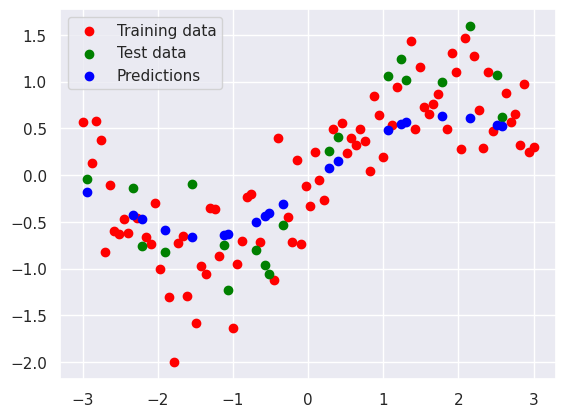

R^2: 0.7207368608373352
RMSE: 0.4613800910191633


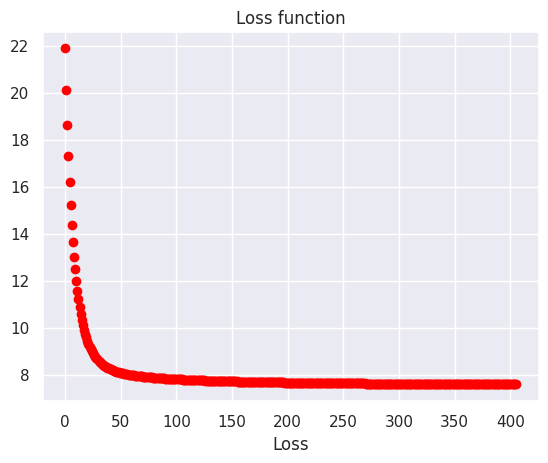

In [153]:
from sklearn.metrics import r2_score, mean_squared_error


np.random.seed(0)
X = np.linspace(-3, 3, 100).reshape(-1, 1)
y = np.sin(X).flatten() + np.random.normal(0, 0.4, X.shape[0])

indices = np.random.permutation(len(X))
train_idx, test_idx = indices[:80], indices[80:]

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

model = KernelRidgeRegression(lr=0.01, regularization=0.1, max_iter=10000, kernel_scale=1.)
model.fit(X_train, y_train)

y_pred = model.predict(X_train, X_test)

plt.scatter(X_train, y_train, color='red', label='Training data')
plt.scatter(X_test, y_test, color='green', label='Test data')
plt.scatter(X_test, y_pred, color='blue', label='Predictions')
plt.legend()
plt.show()

r2 = r2_score(y_test, y_pred)
print(f'R^2: {r2}')

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

plt.scatter(np.arange(len(model.loss_history)), model.loss_history, color='red')
plt.title('Loss function')
plt.xlabel('Iteration')
plt.xlabel('Loss')
plt.show()


100%|██████████| 50/50 [00:00<00:00, 6892.40it/s]


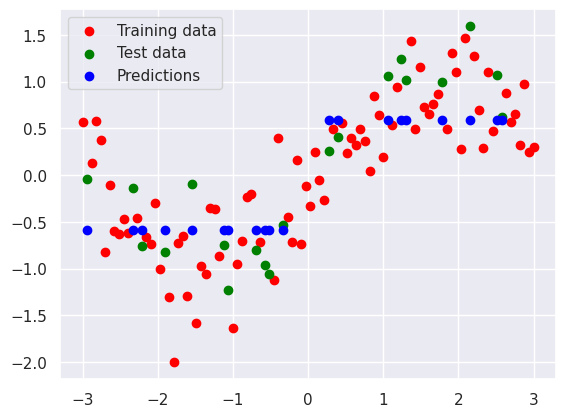

R^2: 0.7346840447446343
RMSE: 0.4497112235800903


In [150]:
from sklearn.metrics import r2_score, mean_squared_error


np.random.seed(0)
X = np.linspace(-3, 3, 100).reshape(-1, 1)
y = np.sin(X).flatten() + np.random.normal(0, 0.4, X.shape[0])

indices = np.random.permutation(len(X))
train_idx, test_idx = indices[:80], indices[80:]

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

model = RFFPipelineRegression(use_PCA=False)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

plt.scatter(X_train, y_train, color='red', label='Training data')
plt.scatter(X_test, y_test, color='green', label='Test data')
plt.scatter(X_test, y_pred, color='blue', label='Predictions')
plt.legend()
plt.show()

r2 = r2_score(y_test, y_pred)
print(f'R^2: {r2}')

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')


Видим, что KernelRidgeRegression почти идеально прошла по синусу, в то время как RFF тоже приблизил синус, но сделал это кусочно-постоянно 